This notebook describes the steps performed to create the *Benthos* product.

In [1]:
using DIVAnd
using PyPlot
using NCDatasets
using Missings
using Interpolations

if VERSION >= v"0.7"
    using Random
    using DelimitedFiles
    using Statistics
    using Printf
    using FileIO
else
    using Compat: @info, @warn, range, cat
end

In [67]:
# Module where the output grid and the reading/writing/ploting modules are defined
include("../src/emodnet_bio_grid.jl");
include("../src/make_benthos_products.jl");

In [69]:
datafile = joinpath(datadir, "Olivier-Benthos/Benthos_Total_densities_ab.csv");
outputfile = joinpath(outputdirBenthos, replace(basename(datafile), ".csv" => ".nc"))

"../output/benthos/Benthos_Total_densities_ab.nc"

## Prepare the grid and the mask

In [61]:
# Grid stored in emodnet_bio_grid.jl
xi,yi = DIVAnd.ndgrid(gridlonBenthos, gridlatBenthos);

# Mask
topodir = "../data/"
topofile = joinpath(topodir, "gebco_30sec_8.nc");

if isfile(topofile)
    bx, by, b = DIVAnd.load_bath(topofile,true,gridlonBenthos, gridlatBenthos);
    xmask, ymask, mmask = DIVAnd.load_mask(topofile,true,gridlonBenthos, gridlatBenthos,[0]);
else
    @error "Bathymetry file doesn't exist"
end
mmask = mmask[:,:,1]
@info size(mmask)

# Metrics
pm = ones(size(xi)) / (xi[2,1]-xi[1,1]);
pn = ones(size(xi)) / (yi[1,2]-yi[1,1]);

┌ Info: (451, 371)
└ @ Main In[61]:15


### Read data

In [37]:
@info "Reading data file $(datafile)"
obslon, obslat, g1, g2, g3 = read_benthos_abs(datafile);
@info extrema(obslat)
@info extrema(obslon)

┌ Info: Reading data file /home/ctroupin/tmp/Emodnet-Bio/Olivier-Benthos/Benthos_Total_densities_ab.csv
└ @ Main In[37]:1
┌ Info: (1.0555555556, 210.0555555556)
└ @ Main In[37]:3
┌ Info: (-9.39937, 203.1666666667)
└ @ Main In[37]:4


### Scatter plot

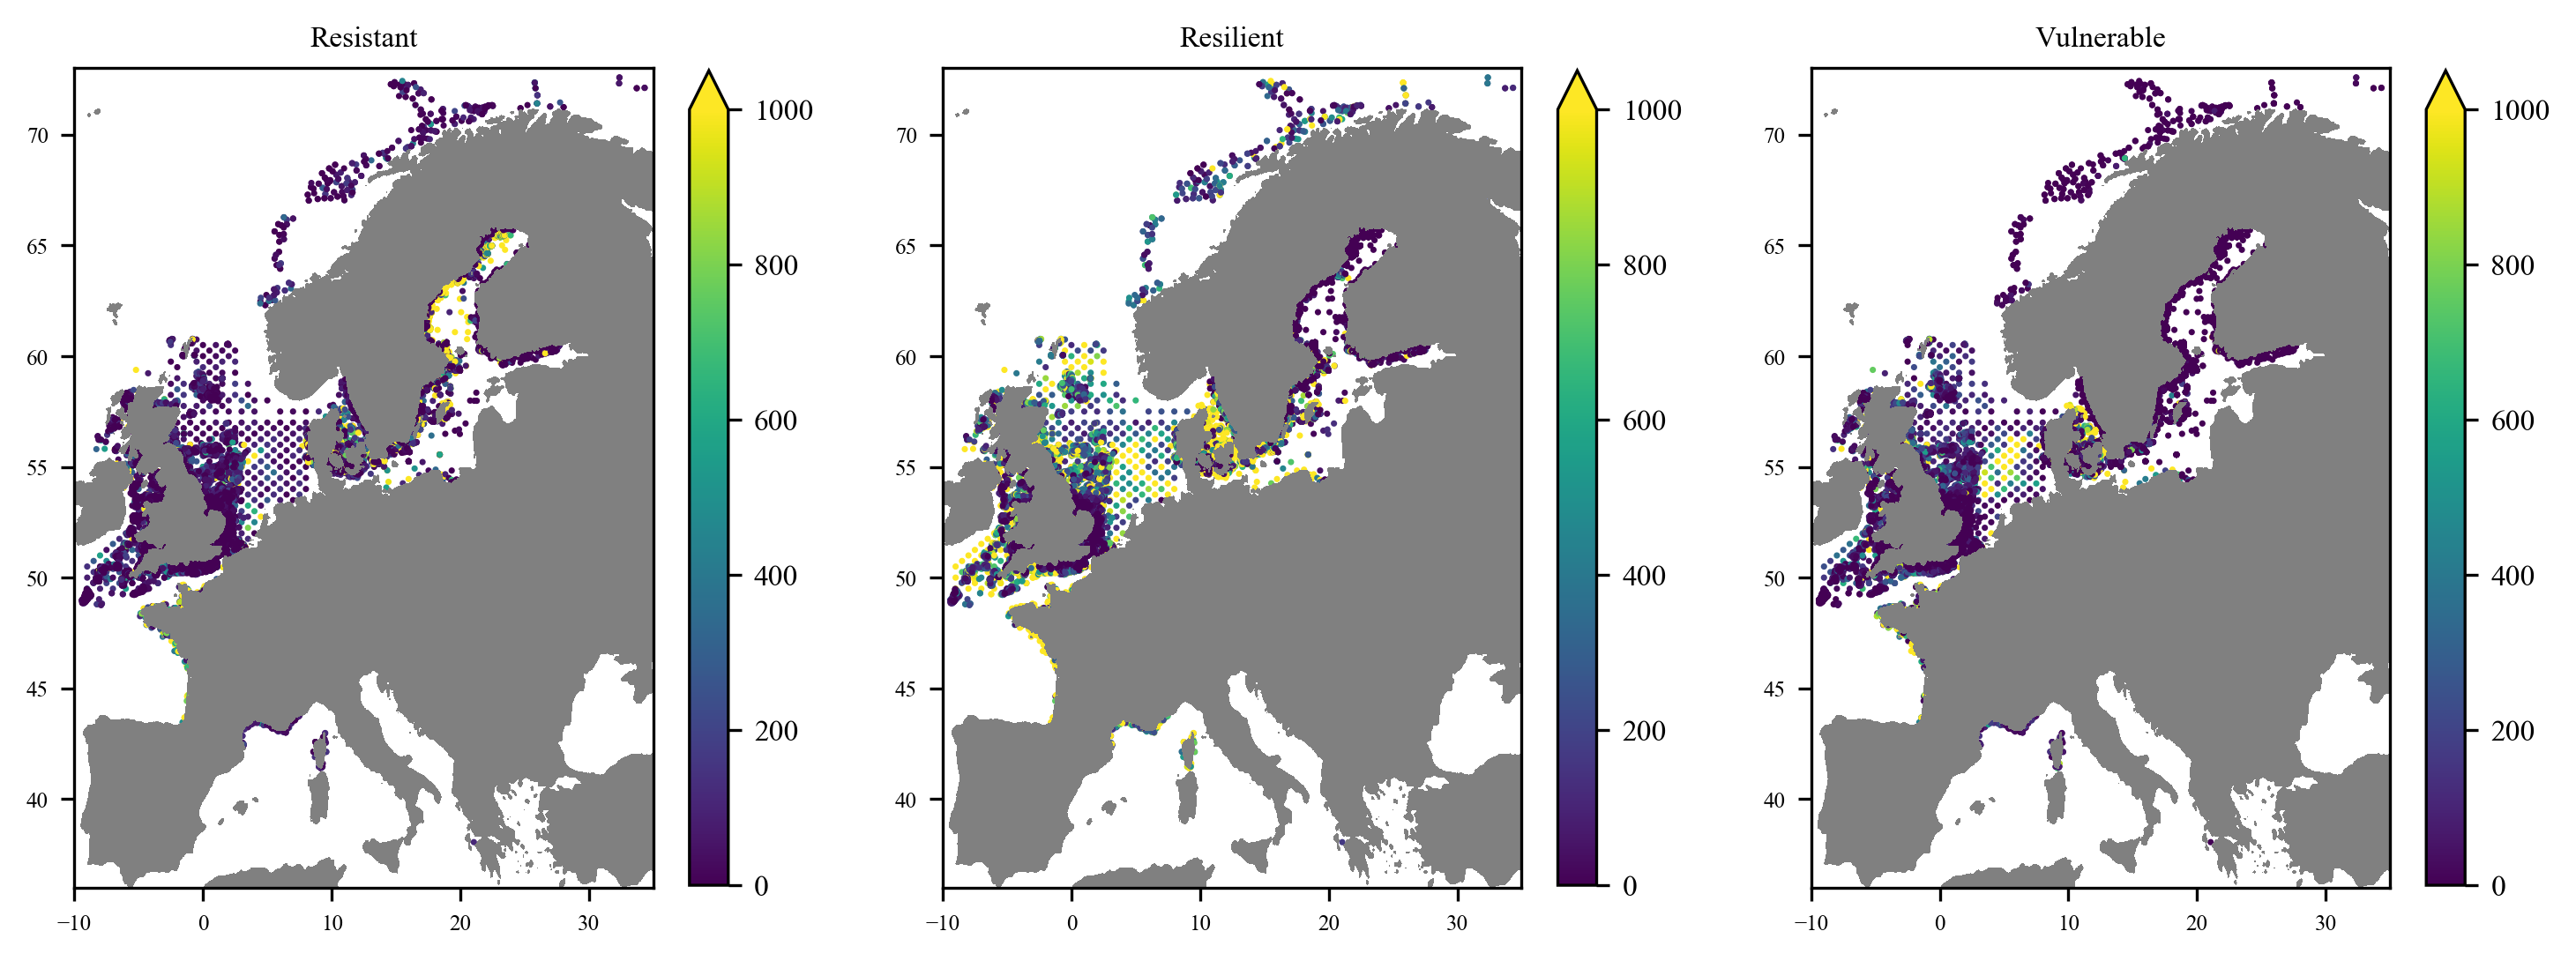

In [70]:
make_scatter_grid(g1, g2, g3)
PyPlot.savefig(joinpath(figdirBenthos, "Benthos_Total_densities_ab_data.png"), 
    dpi=300, bbox_inches="tight")

## Parameter choice 
Chose via sensitivity analysis, as the optimisation tools provide too low values for L and noise-to-signal ratio.

In [64]:
# Correlation length
len = 2.;
# Observational error variance normalized by the background error variance
epsilon2 = 5.;

The weight is decreased for very close points.

In [65]:
rdiag=1.0./DIVAnd.weight_RtimesOne((obslon, obslat),(0.03,0.03))
@show maximum(rdiag),mean(rdiag);
epsilon2 = epsilon2*rdiag;

(maximum(rdiag), mean(rdiag)) = (439.4143004395609, 33.622283414778)


## Perform analysis

In [66]:
@info "Interpolating"
fi1rel, fi2rel, fi3rel, totalfield = make_analysis(obslon, obslat, g1, g2, g3);

┌ Info: Interpolating
└ @ Main In[66]:1


  1.472015 seconds (2.30 M allocations: 1.450 GiB, 43.27% gc time)
  1.403248 seconds (2.30 M allocations: 1.450 GiB, 40.96% gc time)
  1.517143 seconds (2.30 M allocations: 1.450 GiB, 41.49% gc time)


### Make plot

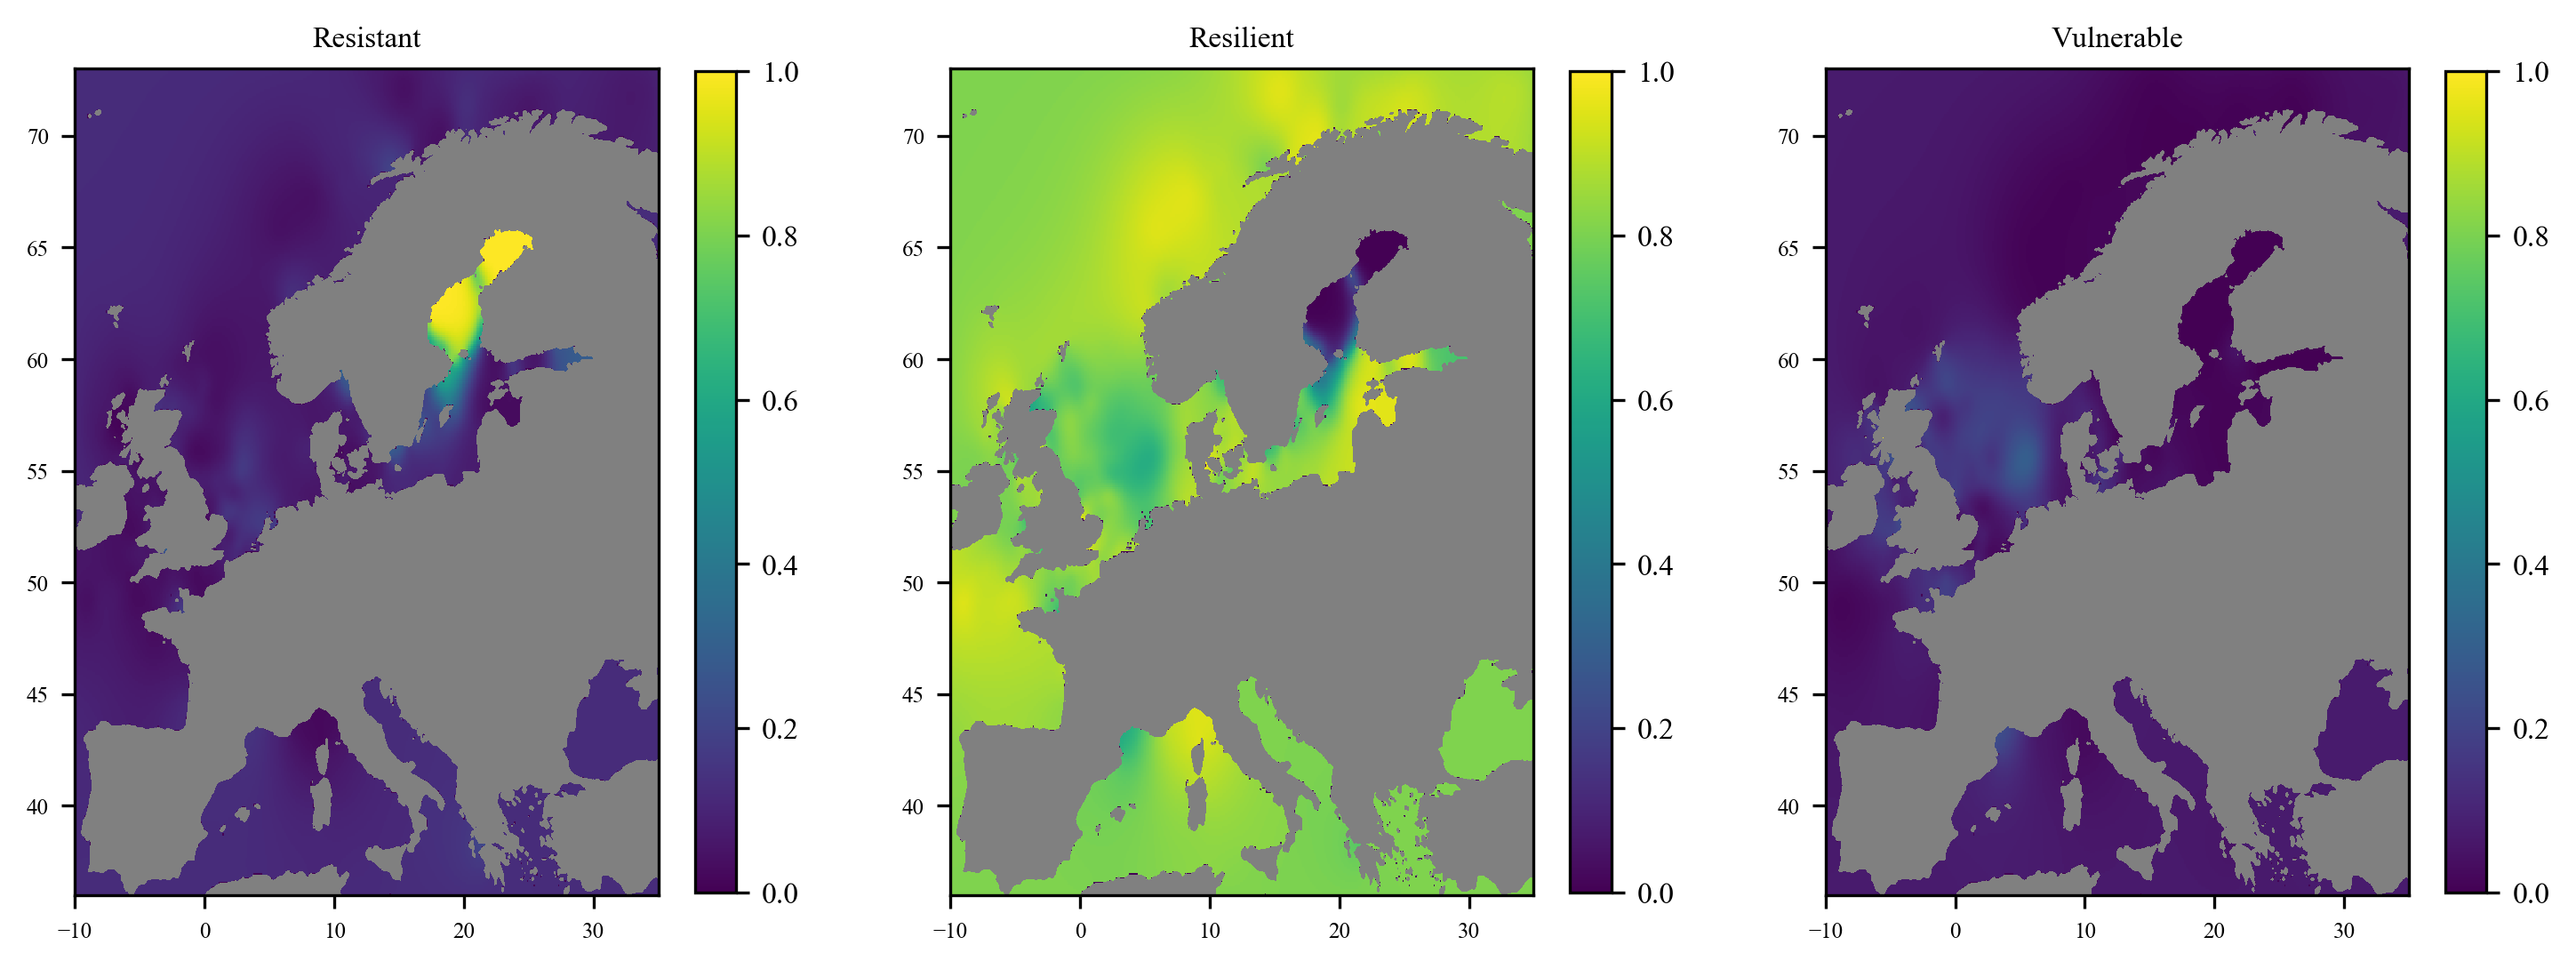

In [71]:
make_plot_benthos(fi1rel, fi2rel, fi3rel, vmin=0., vmax=1.)
PyPlot.savefig(joinpath(figdirBenthos, "Benthos_Total_densities_ab.png"), 
    dpi=300, bbox_inches="tight")

## Error field
We use the so-called *Clever Poor Man's Estimate*.

In [46]:
g1_err, g2_err, g3_err = compute_error(obslon, obslat, g1, g2, g3);

### Make plot

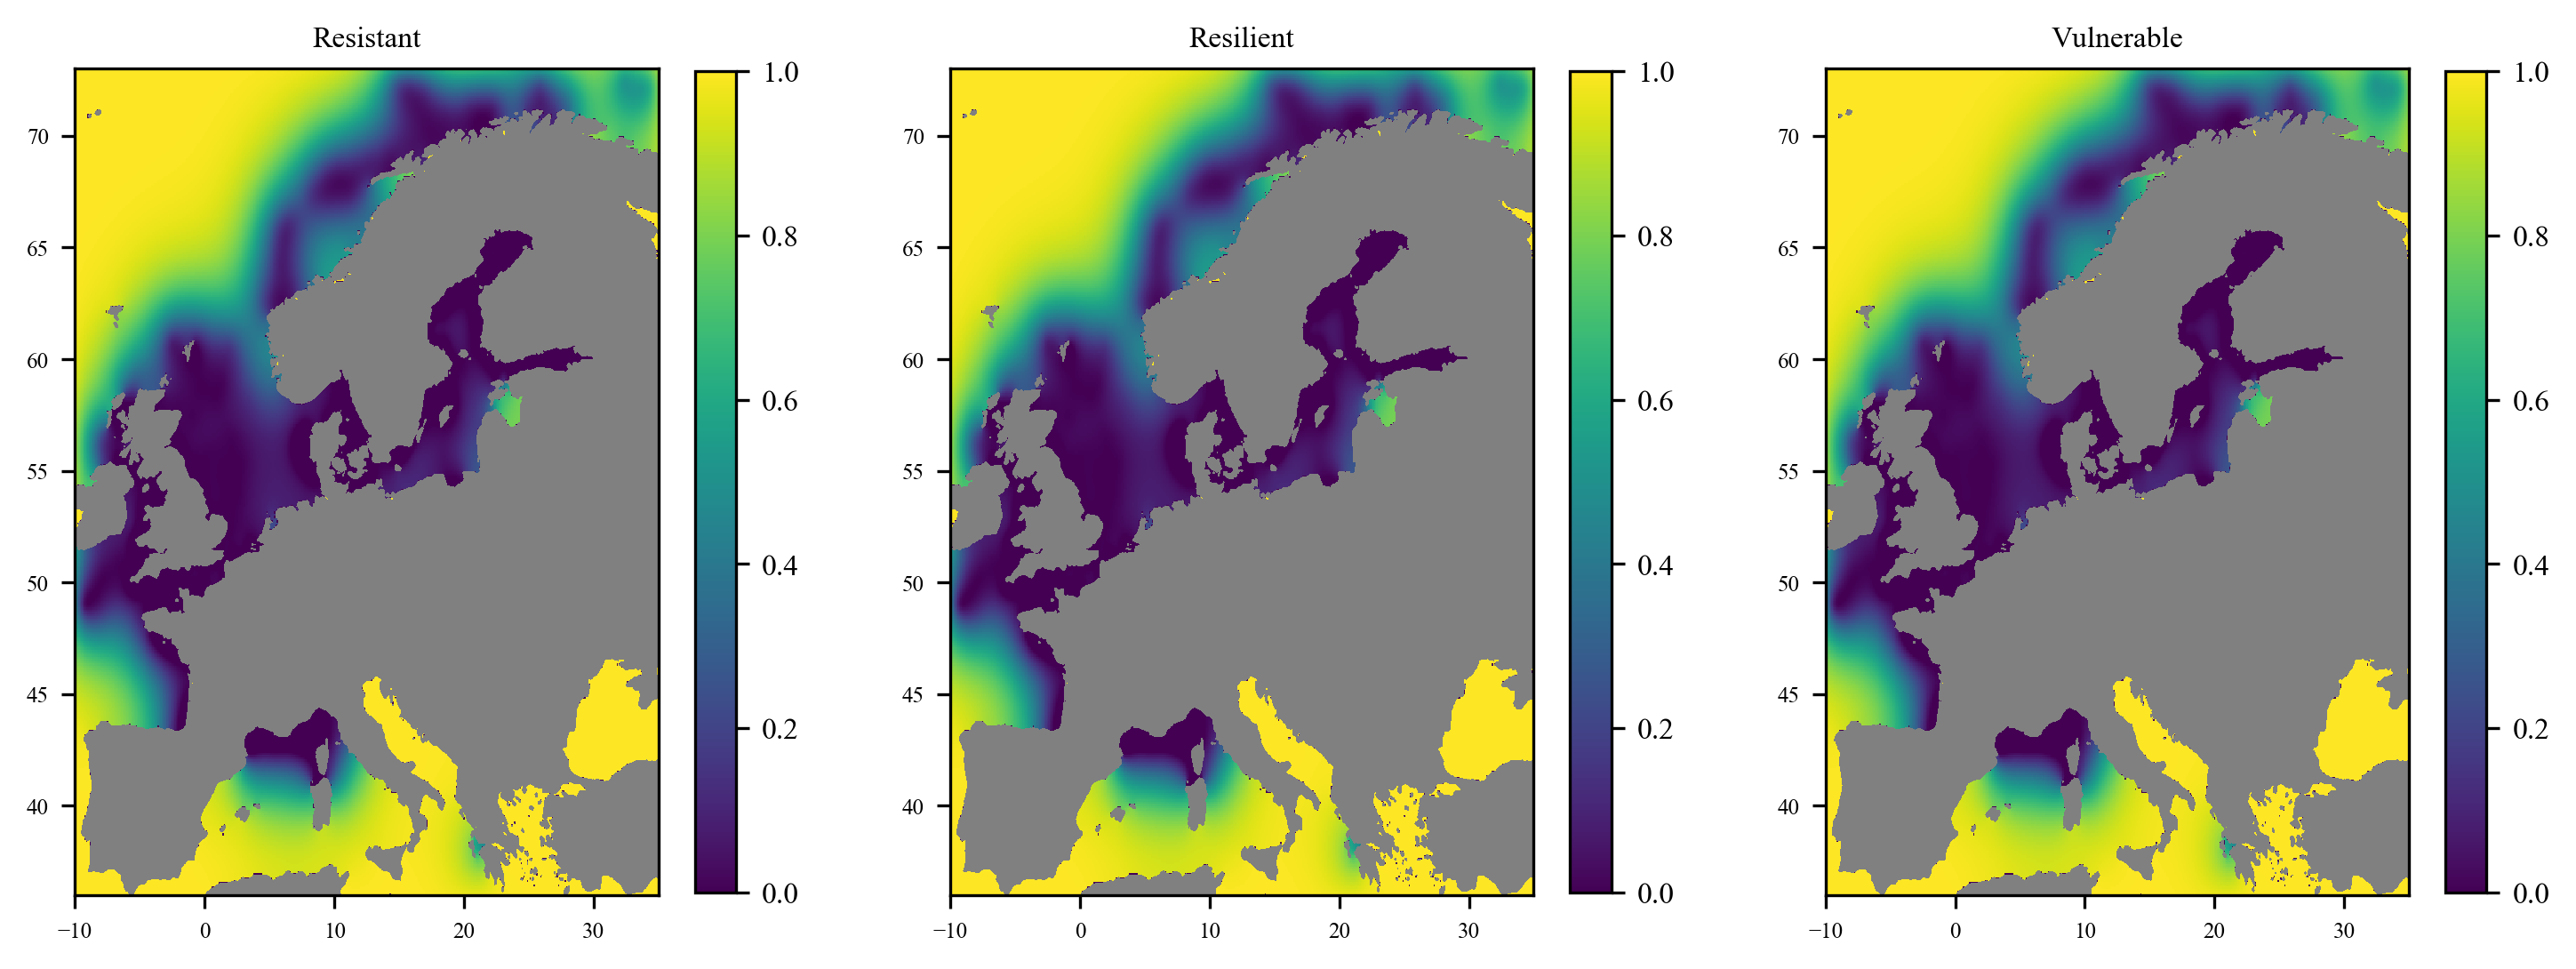

In [72]:
make_plot_benthos(g1_err, g2_err, g3_err, vmin=0, vmax=1.)
PyPlot.savefig(joinpath(figdirBenthos, "Benthos_Total_densities_ab_error.png"), 
    dpi=300, bbox_inches="tight")

## Write the results and the error field in a netCDF file
Create new output directory if necessary.

In [73]:
@info "Write netCDF file $(outputfile)"
write_benthos_nc(outputfile, gridlonBenthos, gridlatBenthos,
fi1rel, fi2rel, fi3rel, g1_err, g2_err, g3_err);

┌ Info: Write netCDF file ../output/benthos/Benthos_Total_densities_ab.nc
└ @ Main In[73]:1


## Analysis of the density file
The same procedure is repeated with the density data.

In [74]:
datafile2 = joinpath(datadir, "Olivier-Benthos/Benthos_Total_densities_tx.csv");
outputfile2 = joinpath(outputdirBenthos, replace(basename(datafile2), ".csv" => ".nc"))

"../output/benthos/Benthos_Total_densities_tx.nc"

### Data reading

In [53]:
@info "Reading data file $(datafile2)"
obslon2, obslat2, g1b, g2b, g3b = read_benthos_abs(datafile2);

┌ Info: Reading data file /home/ctroupin/tmp/Emodnet-Bio/Olivier-Benthos/Benthos_Total_densities_tx.csv
└ @ Main In[53]:1


### Parameters
We make the analysis with the same values for the parameters.

In [54]:
# Correlation length
len = 2.;
# Observational error variance normalized by the background error variance
epsilon2 = 5.;
# Decreasing weight for close observations
rdiag=1.0./DIVAnd.weight_RtimesOne((obslon2, obslat2),(0.03,0.03))
@show maximum(rdiag),mean(rdiag);
epsilon2 = epsilon2*rdiag;

(maximum(rdiag), mean(rdiag)) = (439.4142964093766, 33.452614788527995)


## Perform analysis and compute error field

In [55]:
@info "Interpolating"
f1brel, f2brel, f3brel, totalfieldb = make_analysis(obslon2, obslat2, g1b, g2b, g3b);
@info "Computing error field"
g1b_err, g2b_err, g3b_err = compute_error(obslon2, obslat2, g1b, g2b, g3b);

┌ Info: Interpolating
└ @ Main In[55]:1


  1.435617 seconds (2.30 M allocations: 1.450 GiB, 40.98% gc time)
  1.379237 seconds (2.30 M allocations: 1.450 GiB, 42.23% gc time)
  1.400322 seconds (2.30 M allocations: 1.450 GiB, 42.09% gc time)


┌ Info: Computing error field
└ @ Main In[55]:3


### Make plot
#### Analysed field

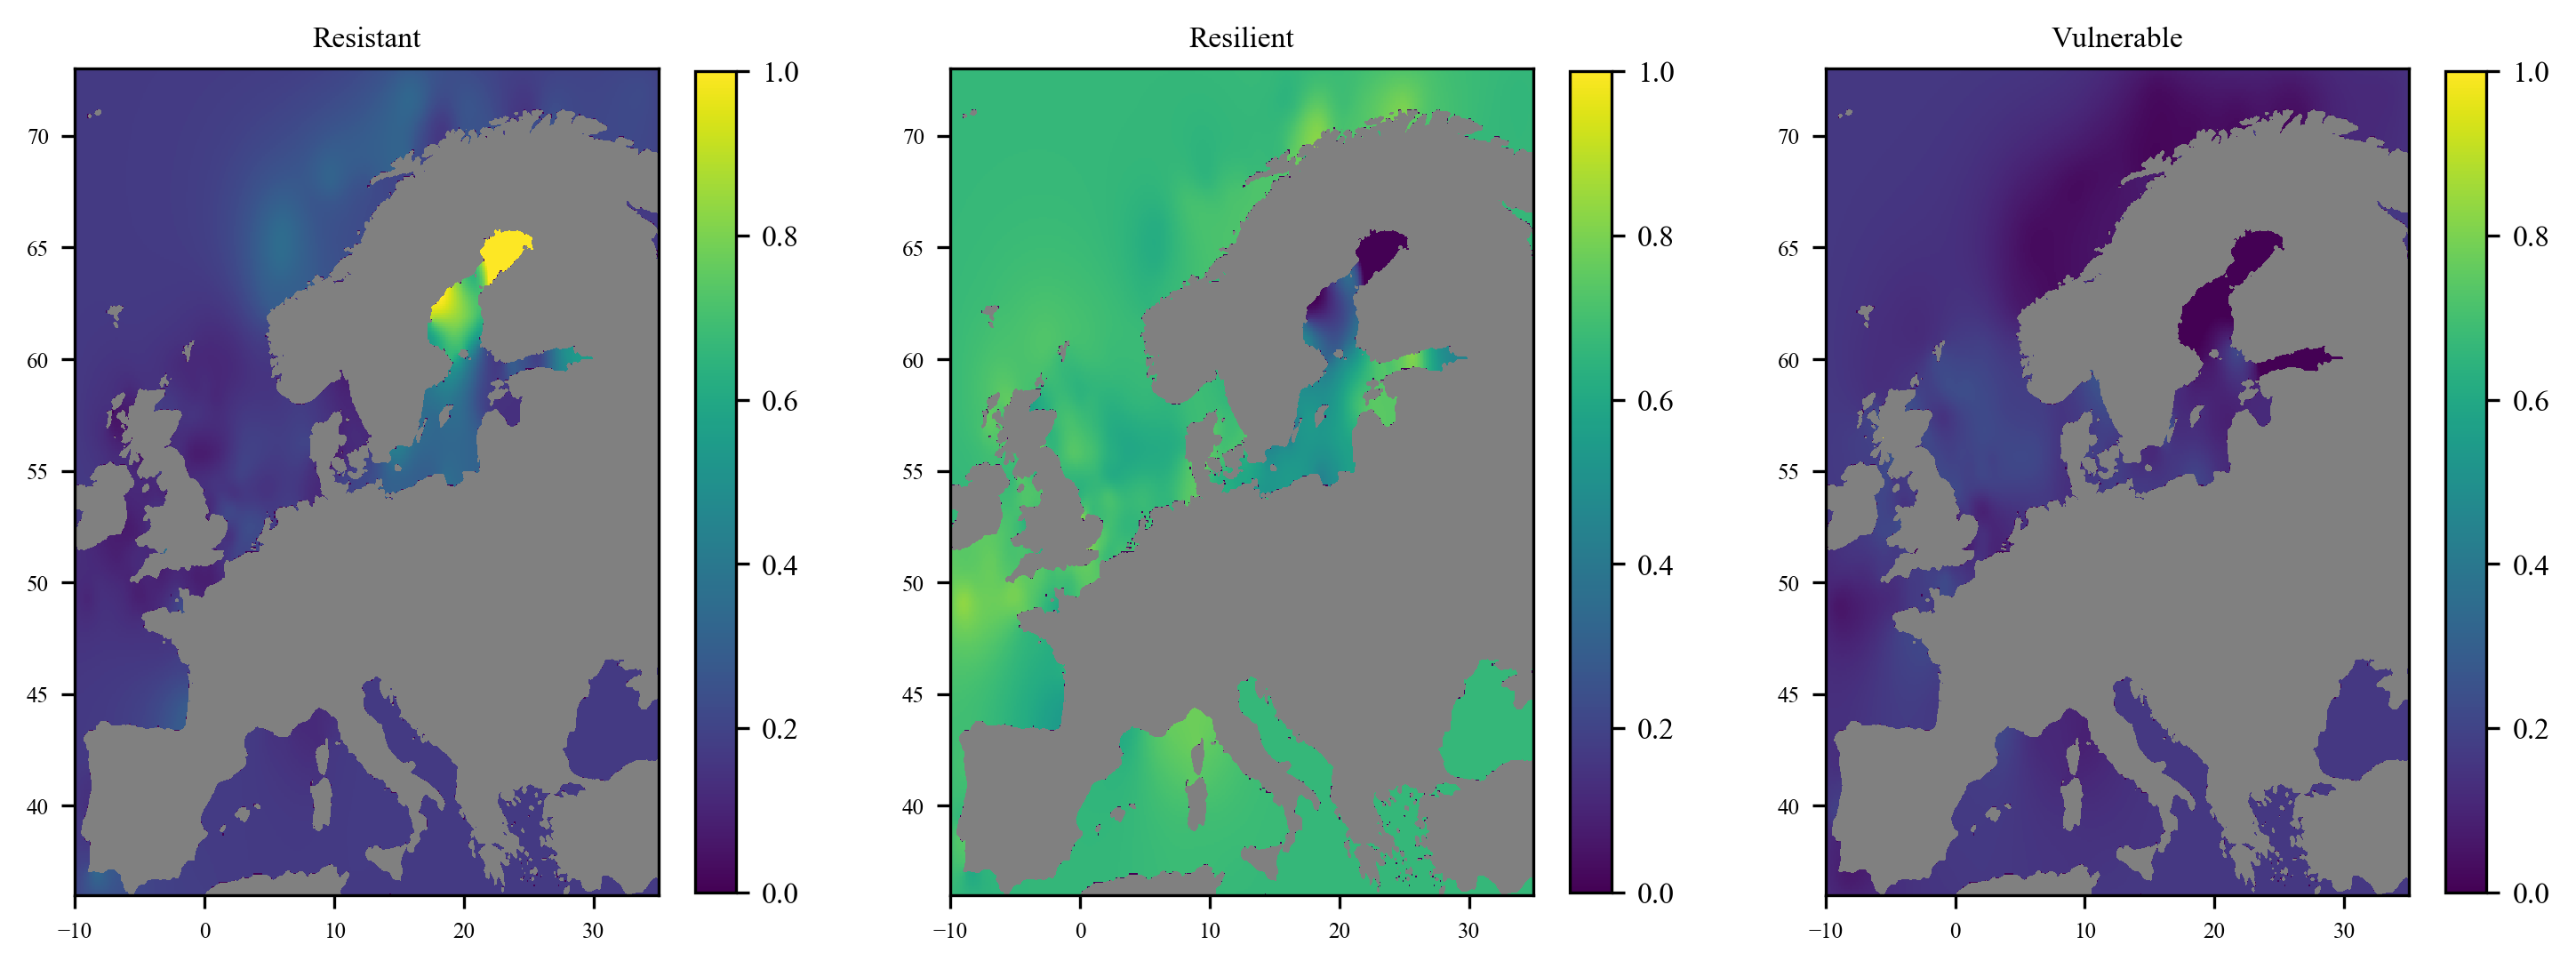

In [56]:
make_plot_benthos(f1brel, f2brel, f3brel, vmin=0., vmax=1.)
PyPlot.savefig(joinpath(figdirBenthos, "Benthos_Total_densities_tx.png"), 
    dpi=300, bbox_inches="tight")

#### Error field

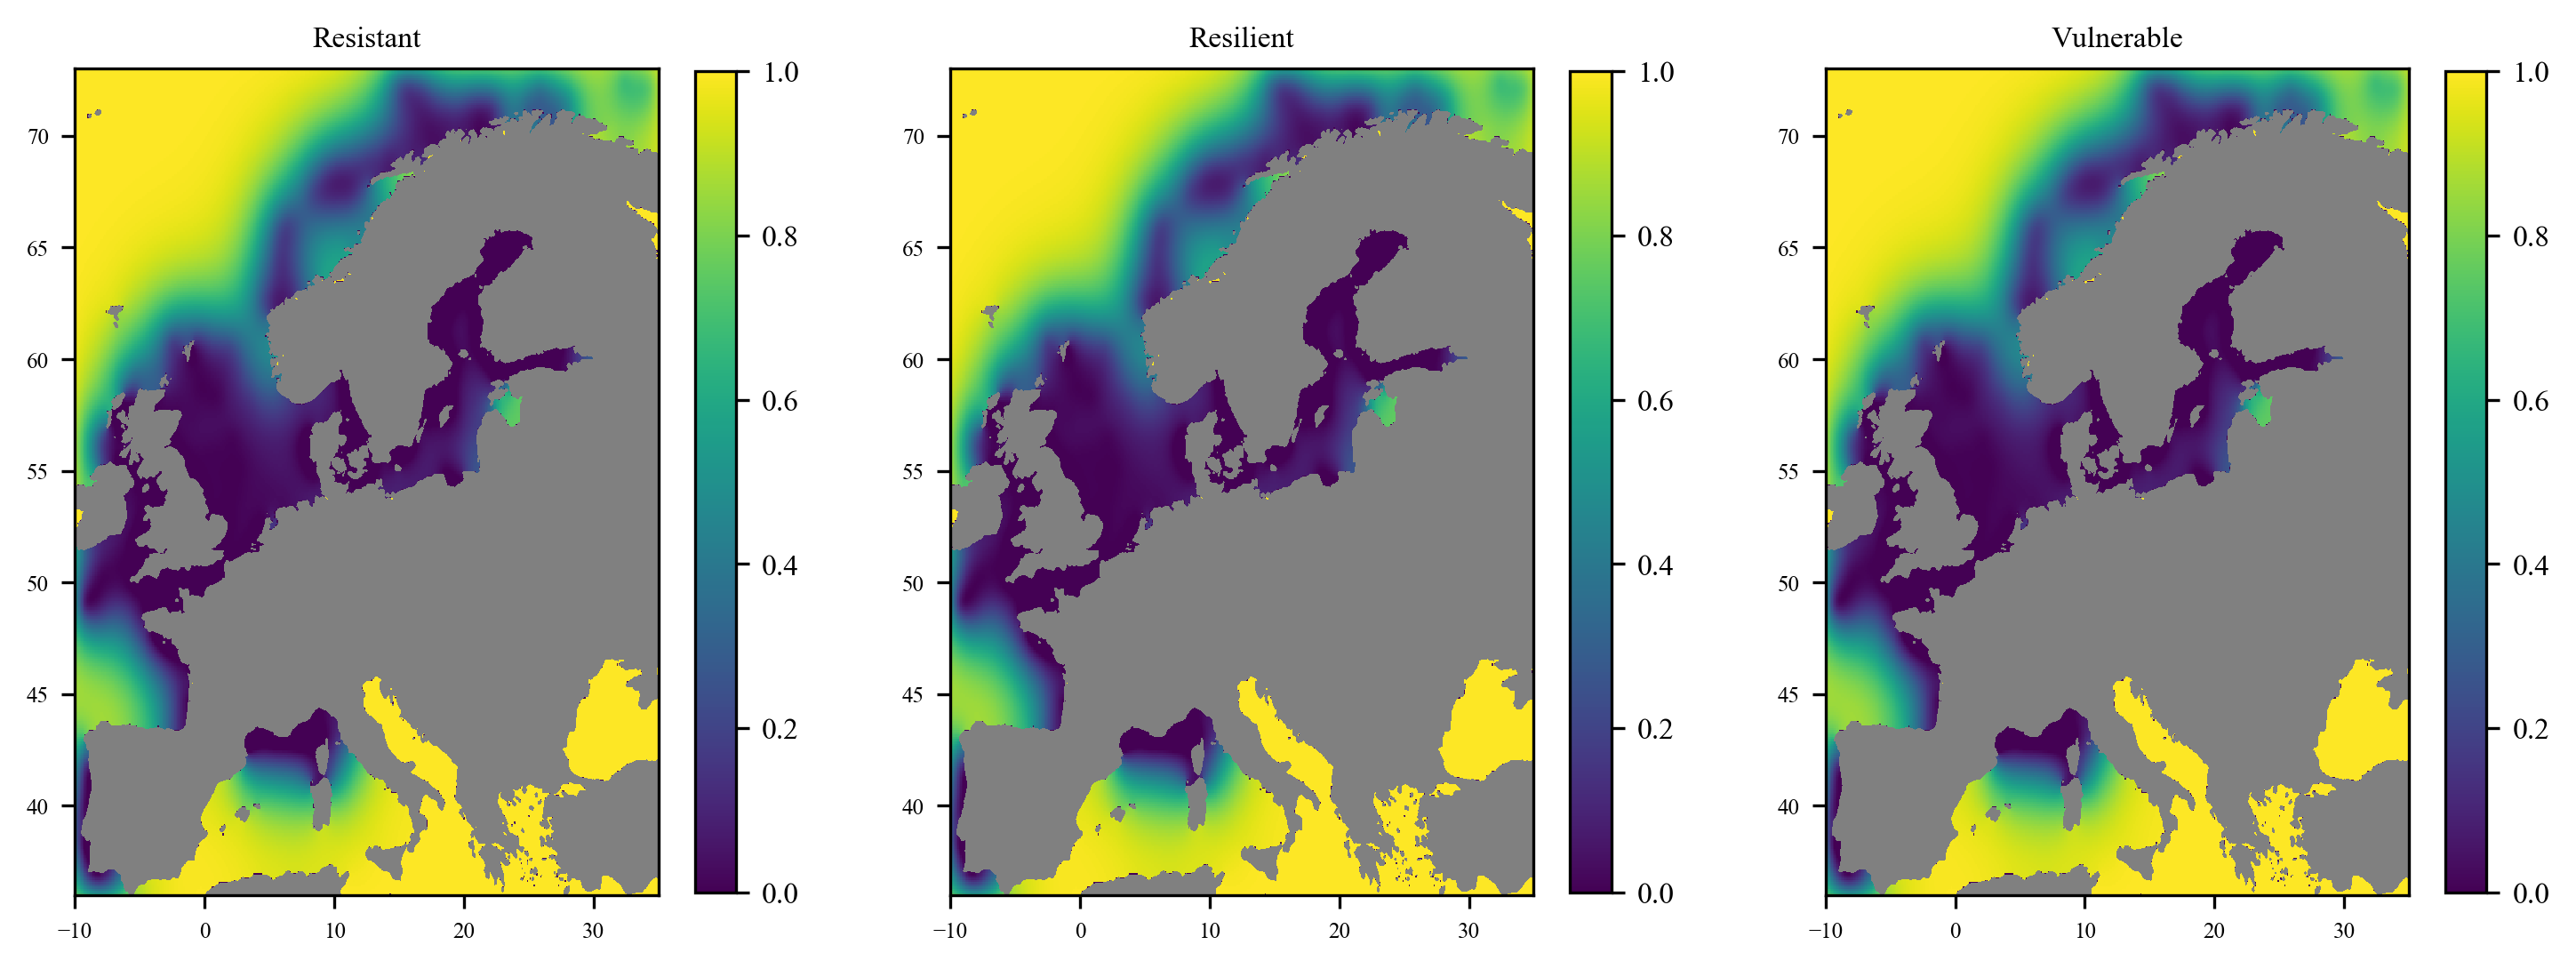

In [75]:
make_plot_benthos(g1b_err, g2b_err, g3b_err, vmin=0., vmax=1.)
PyPlot.savefig(joinpath(figdirBenthos, "Benthos_Total_densities_tx_error.png"), 
    dpi=300, bbox_inches="tight")

### Write netCDF

In [76]:
@info "Write netCDF file $(outputfile2)"
write_benthos_nc(outputfile2, gridlonBenthos, gridlatBenthos,
    f1brel, f2brel, f3brel, g1b_err, g2b_err, g3b_err);

┌ Info: Write netCDF file ../output/benthos/Benthos_Total_densities_tx.nc
└ @ Main In[76]:1
